In [48]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from random import randint
from scipy.linalg import qr
from collections import defaultdict
from tqdm import tqdm

BAD = ['VT', 'VFb', 'VFt'] # KIS,S

In [2]:
# DEFINE WHERE ALL OF THE FILES ARE - UNLABED EXCEPT BY NAME
dir_path = r'C:\Users\jodge\Documents\School\Summer24\tinyml_contest_data_training'
directory_files = os.listdir(dir_path)
num_files = len(directory_files)

# GET INFO TO ACCESS THOSE FILES
root_project_path = r'C:\Users\jodge\Documents\School\Summer24\tinymlcontest2022_demo_example'
label_filename = r'label_list.csv' # in demo path - Maps abbrevations to full medical names of conditions. small file.
indices_path = os.path.join(root_project_path, 'data_indices')

test_filename = r'test_indice.csv'  # in label path
train_filename = r'train_indice.csv' # in label path

test_path = os.path.join(indices_path, test_filename)
train_path = os.path.join(indices_path, train_filename)

df_test_indices = pd.read_csv(test_path, sep=",", header=0)
df_train_indices = pd.read_csv(train_path, sep=",", header=0)

#####

label_path = os.path.join(root_project_path, label_filename)
df_labels = pd.read_csv(label_path, sep=',', header=0)

label_dict = {k : v for k,v in df_labels.values} # Afs : Atrial Fibrillation, etc.

In [3]:
def saveObj(obj, filename = "C.pkl"):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)

def readObj(filename = "C.pkl"):
    with open(filename, 'rb') as file:
       return pickle.load(file)

def readFile(filename):
    return pd.read_csv(os.path.join(dir_path, filename), header=None).to_numpy().flatten()

def getRandomFile(): #includes test and train, just a dummy testing helper method
    random_idx = randint(0,len(df_train_indices))
    filename = df_train_indices.Filename[random_idx]
    file_path = os.path.join(dir_path, filename)
    reader = pd.read_csv(file_path, sep = " ", header = None)
    return reader.to_numpy().flatten(), filename
    
def averageSignals(signals):
    arrays = [readFile(file) for file in signals]
    stacked = np.stack(arrays) 
    return np.mean(stacked, axis=0)
    
def getAveragedCategorySignals(): #only training data
    holder = {}
    signals = {}
    for label in label_dict.keys():
        holder[label] = [] # initialize holder 
    for filename in df_train_indices.Filename:
        temp = filename.split('-')
        cat = temp[1] # gets the label category
        holder[cat].append(filename)
        
    for label, file_list in holder.items():
        signals[label] = averageSignals(file_list)
    return signals

def getAverageSignal():
    return averageSignals(df_train_indices.Filename)

def getFullTrainSignalMatrix(): #all files with each as a column
    arrays = [readFile(file) for file in df_train_indices.Filename]
    return np.stack(arrays, axis=1)
    
def plotSignal(n, x, title, sampleLength = 5):
  t = np.linspace(0, sampleLength, n)
  plt.plot(t, x)
  plt.title(title)
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
  plt.show()

def sampleSignal(C, x):
  return C @ x

In [6]:
def svd(x):
    U, S, VT = np.linalg.svd(x, full_matrices=True)
    S = np.diag(S)
    return (U, S, VT)
    
def reconstruct(U, S, VT, r = 500):
    return U[:,:r] @ S[:r,:r] @ VT[:r,:]

def plotCumSum(S):
    plt.plot(np.cumsum(np.diag(S))/np.sum(np.diag(S)))
    plt.title('Singular Values: Cumulative Sum')
    plt.show()

In [7]:
# def plotRanksMSEs(U, S, VT, this_range = range(50, 1250, 100)):
#     ranks = []
#     mses = []
#     for r in this_range:
#         Xapprox = reconstruct(U, S, VT, r)
#         mse = np.mean((fullTrainSignalMatrix - Xapprox) ** 2)
#         ranks.append(r)
#         mses.append(mse)
#     plt.plot(ranks, mses)
#     plt.title('MSE per Rank')
#     plt.show()
    
#     with open(r"results/svd_results.csv", "a+") as f:
#         for rank,mse in zip(ranks, mses):
#             f.write(f"{rank},{mse}\n")

In [8]:
fullTrainSignalMatrix = getFullTrainSignalMatrix()
catSigs = getAveragedCategorySignals()
U, S, VT = svd(fullTrainSignalMatrix)

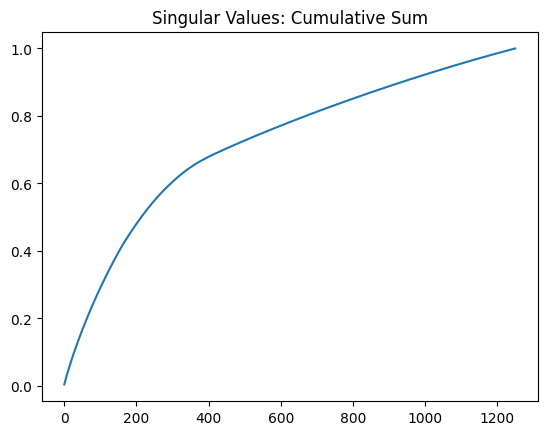

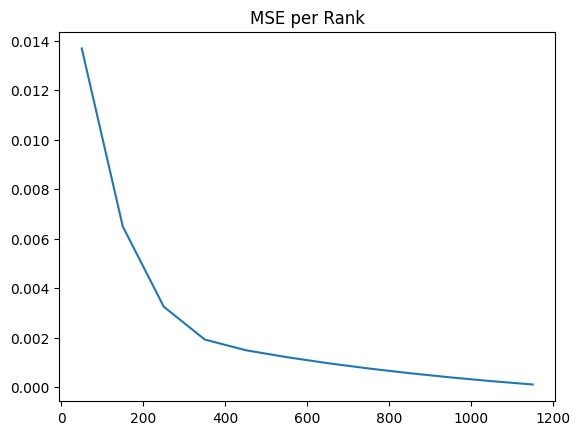

FileNotFoundError: [Errno 2] No such file or directory: 'results/svd_results.csv'

In [9]:
ranks = []
mses = []

for r in range(50, 1250, 100):
    Xapprox = reconstruct(U, S, VT, r)
    mse = np.mean((fullTrainSignalMatrix - Xapprox) ** 2)
    ranks.append(r)
    mses.append(mse)
    
plotCumSum(S)
plt.plot(ranks, mses)
plt.title('MSE per Rank')
plt.show()

with open(r"results/svd_results.csv", "a+") as f:
    for rank,mse in zip(ranks, mses):
        f.write(f"{rank},{mse}\n")

In [ ]:
from scipy.linalg import qr
p = 500 # number of sensors
r = 400 # our truncated rank count
#print(f"p, r = {p}, {r}")

#reshape SVD according to r
U_hat, S_hat, VT_hat = U[:,:r], S[:r,:r], VT[:r,:]

Q, R, pivots = None, None, None

if (p == r):
    Q, R, pivots = qr(U_hat, pivoting = True) # or maybe just U
elif (p > r): # oversampled
    Q, R, pivots = qr(U_hat @ U_hat.T, pivoting = True) # or maybe just U
else:
    for _ in range(100):
        print("ERROR p < r")
pivots = pivots[:p]

# Create C matrix
C = np.zeros((p, fullTrainSignalMatrix.shape[0]))
print(f"C shape: {C.shape}")
C[np.arange(p), pivots] = 1

# print(f"U, S, VT shapes: {U_hat.shape}, {S_hat.shape}, {VT_hat.shape}")
# print(f"Q, R, pivots shapes: {Q.shape, R.shape, pivots.shape}")
# print(pivot)

In [ ]:
def measureAndReconstruct(signal) -> float:
    # Measure a signal
    y = C @ signal
    
    # Solve for coefficients #CLAUDE assisted here down
    U_k_reduced = U_hat[:, :p][pivots, :]
    #print(C.shape, U_hat.shape, U_k_reduced.shape, y.shape, U_hat[:,:][pivots,:].shape)
    if p > r:
        a = np.linalg.lstsq(U_k_reduced, y, rcond=None)[0]
    else:
        a = np.linalg.pinv(C @ U_hat) @ y # idk how to make this work
      
    # Reconstruct the signal
    #x_reconstructed = U[:, :p] @ a
    x_reconstructed = U_hat @ a
    mseFinal = np.mean((signal - x_reconstructed) ** 2)
    return mseFinal

# for _ in range(10):
#     random_col = randint(0, len(fullTrainSignalMatrix))
#     signal = fullTrainSignalMatrix[:,random_col]
#     print(measureAndReconstruct(signal))

#catSigs = getAveragedCategorySignals()
#print(catSigs)
for label, signal in catSigs.items():
    #print(signal)
    print(label, "\tdeath\t" if label in BAD else "\tokay\t", measureAndReconstruct(signal))


# Per Person Exploration

In [108]:
def readObj(filename):
    print(f"reading from {filename}")
    with open(filename, 'rb') as file:
       return pickle.load(file)
def saveObj(obj, filename):
    print(f"saving to {filename}")
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)  

class SVD:
    def __init__(self, U, S, VT):
        self.U = U
        self.S = S
        self.VT = VT

class ProblemSetup:
  def __init__(self, r, p, truncSVD, Q, R, pivots, C): #fullSVD,
      self.r = r # ranks to use
      self.p = p # number of sensors
      #self.fullSVD = fullSVD
      self.truncSVD = truncSVD
      self.Q = Q
      self.R = R
      self.pivots = pivots
      self.C = C
      
def getFullTrainSignalMatrix(): #all files with each as a column
    pkl_name = r"fullTrainMat.pkl"
    pkl_loc = os.path.join("data", pkl_name)

    if os.path.exists(pkl_loc):
        answer = readObj(pkl_loc)
        return answer
    else:
        print(f"{pkl_loc} not found - see other notebooks for generation")
        
def processData(trainingData, label, r = 400, p = 500): # r = ranks desired, p = num sensors. bug when r=p, math is hard.
    pkl_name = f"{label}_r{r}_p{p}.pkl"
    pkl_loc = os.path.join("data", pkl_name)

    if os.path.exists(pkl_loc):
        answer = readObj(pkl_loc)
        return answer
    
    U, S, VT = svd(trainingData)
    #full_SVD = SVD(U, S, VT)
    
    #reshape SVD according to r
    U_hat, S_hat, VT_hat = U[:,:r], S[:r,:r], VT[:r,:]
    trunc_SVD = SVD(U_hat, S_hat, VT_hat)
    
    Q, R, pivots = None, None, None
    if (p == r):
        Q, R, pivots = qr(U_hat, pivoting = True) # or maybe just U
    elif (p > r): # oversampled
        Q, R, pivots = qr(U_hat @ U_hat.T, pivoting = True) # or maybe just U
    else:
        for _ in range(100):
            print("ERROR p < r")
            
    pivots = pivots[:p]
    
    # Create C matrix
    C = np.zeros((p, getFullTrainSignalMatrix().shape[0]))
    #print(C.shape, pivots.shape)
    C[np.arange(p), pivots] = 1

    problemSetup = ProblemSetup(r, p,  trunc_SVD, Q, R, pivots, C) #full_SVD,
    #filename = os.path.join("data", label + ".pkl")
    saveObj(problemSetup, pkl_loc)
    
    return problemSetup
    
def svd(x = getFullTrainSignalMatrix()):
    U, S, VT = np.linalg.svd(x, full_matrices=True) #full_matrices=False
    S = np.diag(S)
    return (U, S, VT)

def measureAndReconstruct(problemSetup, signal):
    # Measure a signal
    C, U_hat, p, r, pivots =  problemSetup.C, problemSetup.truncSVD.U, problemSetup.p, problemSetup.r, problemSetup.pivots
    y = C @ signal
    
    # Solve for coefficients
    U_k_reduced = U_hat[:, :p][pivots, :] # suggested to try
    #print("cond", np.linalg.cond(U_k_reduced), np.linalg.cond(U_hat))
    
    if p == r:
        #a = np.linalg.lstsq(U_k_reduced, y, rcond=None)[0]
        #a = np.linalg.solve(C @ U_hat, y)
        #a = np.linalg.pinv(U_k_reduced) @ y
        #reg_param = 1e-6
        #a = np.linalg.lstsq(U_k_reduced + reg_param * np.eye(U_k_reduced.shape[0]), y, rcond=None)[0]
        #a = np.linalg.inv(C @ U_hat) @ y
        a = np.linalg.lstsq(C @ U_hat, y, rcond=None)[0]
    else:
        a = np.linalg.pinv(C @ U_hat) @ y

    x_reconstructed = U_hat @ a
    mseFinal = np.mean((signal - x_reconstructed) ** 2)
    return mseFinal, x_reconstructed

def cumSum(S):
    return np.cumsum(np.diag(S))/np.sum(np.diag(S))

reading from data\fullTrainMat.pkl


In [ ]:
# patient_nums = set()
# patient_labels = defaultdict(list)
# for fi in directory_files:
#     parts = fi.split('-')
#     pn = parts[0][1:]
#     label = parts[1]
#     patient_nums.add(pn)
#     if label not in patient_labels[pn]:
#         patient_labels[pn].append(label)
# #patient_labels

In [ ]:
patient_labels_training = defaultdict(list)
for fi in df_train_indices.Filename:
    parts = fi.split('-')
    pn = parts[0][1:]
    label = parts[1]
    if label not in patient_labels_training[pn]:
        patient_labels_training[pn].append(label)
patient_labels_training

In [ ]:
r = 500
p = 500
plt.figure(dpi=400)
holder = defaultdict(list)
for file in tqdm(df_train_indices.Filename):
    parts = file.split('-')
    pn = parts[0][1:]
    label = parts[1]
    newkey = pn+label
    holder[newkey].append(np.loadtxt(os.path.join(dir_path, file)))
#print(sorted(list(temp)))

newholder = {}
for nk, arr in holder.items():
    newholder[nk] = np.stack(arr, axis = 1)
    
    pn = nk[:2]
    label = nk[2:]
    n = newholder[nk].shape[1]
    
    #print(pn, label, newholder[nk].shape[1])
    #newholder[nk] = np.sum(arr, axis=0)

for pn, labels in patient_labels_training.items():
    n = len(labels)
    patient_training = np.concatenate([newholder[pn+l] for l in labels], axis=1)
    print("patient training looks like ",pn, labels, patient_training.shape)
                                
    U, S, VT = np.linalg.svd(patient_training, full_matrices=False) #full_matrices=False
    S = np.diag(S)
    #print("SVD", U.shape, S.shape, VT.shape)
    
    
    fig, ax = plt.subplots(2,n+1, figsize=(16,8))
    ax[0,0].plot(cumSum(S))
    ax[0,0].set_title(f'S{pn} ALL - {patient_training.shape[1]} files')
    ax[1,0].plot(np.sum(patient_training, axis=1))
    ax[1,0].set_title(f'S{pn} ALL - {patient_training.shape[1]} files')
    for i,l in enumerate(labels):
        style ='b-' if l not in BAD else 'r-'
        newkey = pn+l
        idx = i+1
        #print(newkey, newholder[newkey].shape)
        _, tS, _ = np.linalg.svd(newholder[newkey], full_matrices=False) #full_matrices=False
        tS = np.diag(tS)
        ax[0,idx].plot(cumSum(tS))
        ax[0,idx].set_title(f'S{pn} {l} - {newholder[newkey].shape[1]} files')
        ax[1,idx].plot(np.sum(newholder[newkey],axis=1),style)
        ax[1,idx].set_title(f'S{pn} {l} - {newholder[newkey].shape[1]} files')
    plt.savefig(f"svdcharts/{pn}.png")
    plt.show()

In [ ]:
r = 500
p = 500

for pn, labels in patient_labels.items():
    print(f"{pn} has {labels}")
    arr = [np.loadtxt(os.path.join(dir_path, file)) for file in df_train_indices.Filename if file.split('-')[0][1:] == pn and file.split('-')[1] == 'SR']

    if len(arr):
        patient_training = np.stack(arr, axis=1)
        patient_sum = np.sum(patient_training, axis=1)
        print(f"S{pn} has {patient_training.shape[1]} files")
    
        #setup = processData(patient_training, "S"+pn, r = r, p = p)
        U, S, VT = np.linalg.svd(patient_training, full_matrices=False) #full_matrices=False
        S = np.diag(S)
        
        print(U.shape, S.shape, VT.shape)
        ranks = []
        mses = []
        
        for r in range(50, 1250, 100):
            Xapprox = U[:,:r] @ S[:r,:r] @ VT[:r,:]
            mse = np.mean((patient_training - Xapprox) ** 2)
            ranks.append(r)
            mses.append(mse)


        fig, ax = plt.subplots(1,3, figsize=(12,4))
        
        ax[0].plot(np.cumsum(np.diag(S))/np.sum(np.diag(S)))
        ax[0].set_title(f'SV: Cum. Sum S{pn}')        
        ax[1].plot(ranks,mses)
        ax[1].set_title(f'MSE per Rank {patient_training.shape[1]}')
        ax[2].plot(patient_sum)
        ax[2].set_title(f'Patient Sum S{pn} {patient_labels[pn]}')
        #plt.plot(ranks, mses)
        #plt.title(f'MSE per Rank for S{pn}')
        plt.show()
    else:
        print(f"patient number {pn} doesn't have any training data")

#['VT', 'VFb', 'VFt'] THEY ARE NOT HEALTHY